# Tracking centroids in succesive layers of k-means (hostility)

In [48]:

import pandas as pd
import copy
from sklearn import preprocessing
import numpy as np
from sklearn.cluster import KMeans
from Normal_dataset_generator import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from TrackingCentroidsMovement import *

from sklearn.datasets import make_blobs, make_classification

In [2]:
import os
os.chdir("..")
root_path = os.getcwd()

Hacemos un minicambio en el algoritmo de la hostilidad para incluir como output los centroides en cada una de las capas. Esta versión se llama hostility_measure_Centroids().

Además, creamos una función llamada plot_hierarchical_quivers_with_complexity() (por ahora solo para 2D) que pinta cómo se van moviendo los centroides en las sucesivas capas y cómo va cambiando su hostilidad. Es un gráfico tipo mapa vectorial con tantos plots como número de capas -1 puesto que va mostrando la transición entre ellos. Las flechas están coloreadas mediante un degradado en función del cambio en la hostilidad (mayor hostilidad es malo y menor hostilidad es bueno) del cluster previo al cluster siguiente. Cada plot muestra el cambio entre una capa y la siguiente. Así, en cada gráfico, las flechas se inician en la posición previa de los puntos y finalizan en el centroide del cluster en el que acaban asignados en la siguiente capa. Recordemos que mediante el parámetro k_auto se seleccionaba de forma automática la última capa a tener en cuenta. Este parámetro también se le pasa a la función del plot del mapa vectorial para que solo se grafiquen aquellas capas aceptadas y evitar ruido.

Aclaramos que este gráfico se utilizará únicamente en 1D y 2D para ir evaluando de forma gráfica si la idea que tenemos de utilizar el movimiento de los centroides y el cambio en complejidad funciona o no. Así, sirve a modo exploratorio, ilustrativo e intuitivo.

### Ejemplo 1: Dos normales solapadas

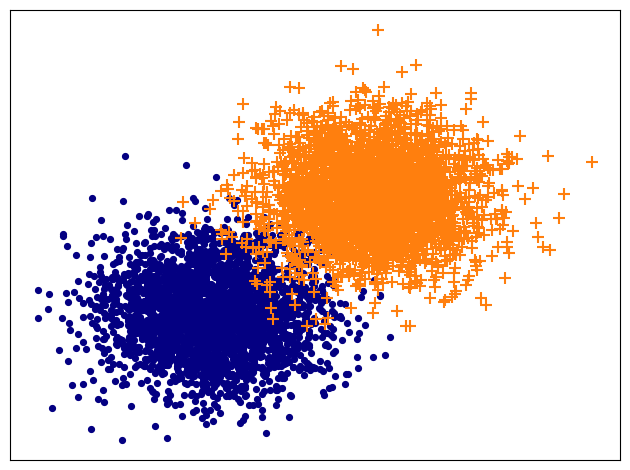

In [3]:
# Parameters
seed1 = 1
seed2 = 2
n0 = 3000
n1 = 3000

# Dataset 1
mu0 = [0, 0]
sigma0 = [[1, 0], [0, 1]]
mu1 = [3, 3]
sigma1 = [[1, 0], [0, 1]]

X, y = normal_generator2(mu0, sigma0, n0, mu1, sigma1, n1, seed1, seed2)

In [4]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(48)

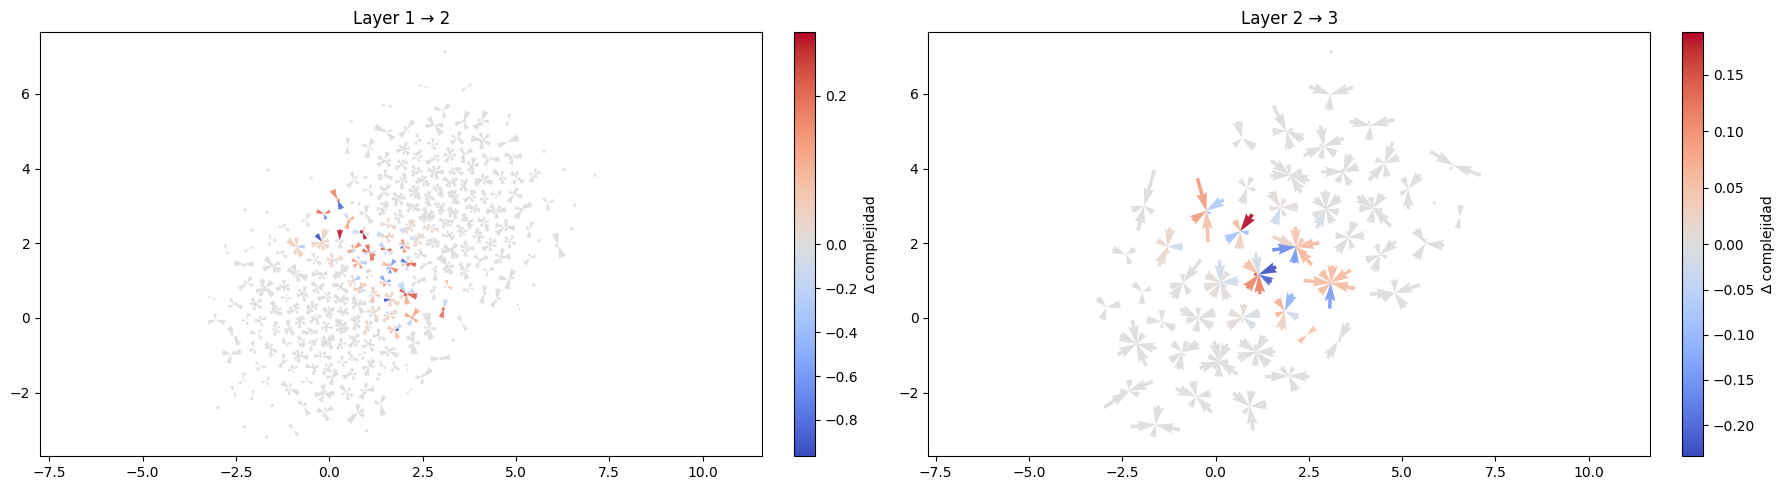

In [5]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=k_auto)

Observamos:
  * Primer gráfico. Movimientos muy pequeños (se pasa de puntos originales a primera tanda de centroides). Los únicos cambios de complejidad ocurren en puntos situados justo en el medio del gráfico. En el resto los cambios son aproximadamente 0.
  * Segundo gráfico. De nuevo, los únicos cambios ocurren en el centro de los datos. Se aprecia que alejarse de ese centro, disminuye la complejidad (flechas azules) y acercarse, aumenta la complejidad (flechas rojas).
  * Tercer gráfico. El patrón del segundo gráfico se vuelve a repetir pero ahora aun más claro.

Con esta visualización queda claro dónde está el lío y hacia donde es mejor moverse para minimizar la complejidad. Debería salir que ambas son importantes. HACER UN EJEMPLO EN 2D CON UNA SUPERFLUA PARA VISUALIZAR ILUSTRATIVAMENTE

Ahora la idea es ver si podemos cuantificar correctamente la magnitud de dichos movimientos con respecto a cada dimensión y con ello elaborar un ranking de utilidad de las variables que nos permita hacer feature selection. “direccionalidad por feature” → es como un gradiente de complejidad en el espacio de variables.


## Primera idea ranking feature selection

1. Descomponer el vector de movimiento. Para cada transición de centroide, vamos a mirar la contribución de cada feature (magnitud del cambio en esa dimensión) y vamos a asociar dicha contribución con el incremento de complejidad que haya ocurrido.
2. Calcular un score por feature. Una primera puede ser:
$$score(f_j) = \sum_{layers\ l_i} \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i)$$ donde $f_j$ indica la variable $j$, es decir, la dimensión $j$. El producto nos diría si movernos en esa dimensión está relacionado con aumentar o reducir complejidad.
3. Realizar un ranking con el score. Si el score es siempre positivo (la hostilidad aumenta), entonces esa variable "empeora" la complejidad, es decir, dificulta la capacidad de discernir entre las clases y deberíamos "eliminarla". Por el contrario, si es negativo, quiere decir que esa variable contribuye a simplificar la estructura de los datos y es una buena candidata.


Comenzamos probando con 5 opciones de ranking:

1. Valor crudo (score_raw). Básicamente es $$score(f_j) = \sum_{layers\ l_i} \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i)$$, es decir, el resultado de ir sumando el cambio de complejidad multiplicada por la magnitud del cambio en la variable.
2. Valor normalizado para que el vector sume 1 y los resultados sean más interpretables. Simplemente es dividir cada valor final por la suma total de los elementos del vector.
3. Versión más robusta en la que además se multiplica por el número de puntos involucrados en cada cluster. Así, se intentaría "igual" el efecto que tienen las distintas capas. En las primeras capas, el número de clusters es más alta (es decir, se añaden más sumandos al score) pero el número de puntos en cada cluster es menor (¡ojo! porque los cambios en complejidad serán más chiquitines, o sea que quizás ya se está contemplando). Por otro lado, en las capas finales el número de clusters es más pequeño (es decir, se añaden pocos sumandos al score) pero la cantidad de puntos agrupado en cada cluster será mayor, así se ponderarán más dichos cambios (¡ojo! porque aquí los cambios en complejidad serán mayores y eso ya hará que tenga más impacto). Este score sería: $$score(f_j) = \sum_{layers\ l_i} \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i) \cdot |Centroid_j(l_i)|$$
4. Versión estandarizada. Nosotros vamos a trabajar con datos estandarizados, pero por si acaso, para evitar que una dimensión se lleve más peso simplemente por el hecho de ser más susceptible a movimientos, podemos hacer el siguiente ajuste: $$score(f_j) = \sum_{layers\ l_i} \frac{ \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i)}{|\sum \Delta Centroid_j(l_i)|}$$
 Cada dimensión se normaliza según cuánto se ha movido en total. Evita que una feature con centroides muy móviles domine aunque su relación con la complejidad sea débil. Es como un “efecto medio por unidad de movimiento en esa dimensión”. Normaliza cada feature respecto a su propio movimiento, para indicar cuánto cambio de complejidad genera por unidad de desplazamiento.
5. Combinación de estandarizada y robustez.


In [6]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=k_auto)

In [7]:
resultados

{'scores': {'raw': {0: -0.51342453397097, 1: -0.15716810604376896},
  'normalized_simple': {0: -0.7656280479900367, 1: -0.23437195200996325},
  'robust': {0: -0.6442374129927246, 1: 4.448001396126757},
  'norm_by_movement': {0: -0.0027905242530824187, 1: -0.0008457089219394481},
  'robust_norm_by_movement': {0: -0.000298569578377916,
   1: 0.002063881627865264}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [0, 1],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([-0.56347708, -0.4041785 ]),
  array([0.05005255, 0.2470104 ])],
 'list_scores_robust': [array([-1.95866033, -1.62176006]),
  array([1.31442292, 6.06976146])],
 'details':       layer_from  cluster_from  cluster_to  n_points  comp_old  comp_new  \
 0              1           0.0          67         2       0.0  0.090909   
 1              1           1.0         128         5       0.0  0.000000   
 2              1           2.0         169        10    

Por ahora nos fijamos en el ranking raw y lo que vemos es que indica que ambas variables aportan de cara a disminuir la complejidad (ambos score son negativos). El score de x es mayor en valor absoluto que el de y, lo que indicaría que la variable x ayuda más a minimizar la complejidad que la y. Visualmente se aprecia que un corte en x es más discriminante que un corte en y. A los otros scores por ahora no les veo chicha.

In [8]:
resultados['details']

,layer_from,cluster_from,cluster_to,n_points,comp_old,comp_new,change_comp,change_0,change_1
0,1,0.0,67,2,0.0,0.090909,0.090909,0.115690,0.088702
1,1,1.0,128,5,0.0,0.000000,0.000000,0.020066,0.078902
2,1,2.0,169,10,0.0,0.000000,0.000000,0.058173,0.176287
3,1,3.0,205,8,0.0,0.071429,0.071429,0.138172,0.127242
4,1,4.0,236,11,0.0,0.000000,0.000000,0.107658,0.175940
...,...,...,...,...,...,...,...,...,...
1435,2,235.0,37,56,0.0,0.000000,0.000000,0.078672,0.019144
1436,2,236.0,39,53,0.0,0.000000,0.000000,0.024164,0.164279
1437,2,237.0,11,2,0.0,0.000000,0.000000,0.242151,0.007217
1438,2,238.0,27,8,0.0,0.000000,0.000000,0.113881,0.645336


In [90]:
def make_synthetic_datasets(n_samples=3000, random_state=42):
    rng = np.random.RandomState(random_state)
    datasets = {}

    # --- 1. 1D en 2D (y = 0 siempre)
    x = np.concatenate([rng.normal(-3, 1, n_samples//2), rng.normal(3, 1, n_samples//2)])
    y = np.zeros_like(x)
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["1D_x_active"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 2. 1D en 2D (x = 0 siempre)
    y = np.concatenate([rng.normal(-3, 1, n_samples//2), rng.normal(3, 1, n_samples//2)])
    x = np.zeros_like(y)
    datasets["1D_y_active"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 3. 2 blobs bien separados
    X, l = make_blobs(n_samples=n_samples, centers=[(0,0),(5,5)], random_state=rng)
    datasets["2D_blobs"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "label": l})

    # --- 4. Relevancia desigual (x discrimina, y ruido)
    x = np.concatenate([rng.normal(0, 1, n_samples//2), rng.normal(5, 1, n_samples//2)])
    y = rng.normal(0, 5, n_samples)
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["2D_x_relevant"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 5. XOR
    # Generamos puntos en [-4,4]×[-4,4]
    x = rng.uniform(low=-4, high=4, size=(400,2))
    # Etiquetas XOR
    sx = (x[:,0] > 0).astype(int)
    sy = (x[:,1] > 0).astype(int)
    # XOR clásico
    y = np.bitwise_xor(sx, sy)
    datasets["2D_XOR"] = pd.DataFrame({"0": x[:,0],"1": x[:,1],"label": y})

    # --- 6. 3D con redundancia (z = x)
    X, l = make_blobs(n_samples=n_samples, centers=[(0,0),(5,5)], random_state=rng)
    z = X[:,0].copy()
    datasets["3D_redundant"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "2": z, "label": l})

    # --- 7. Concéntricos
    angles = rng.uniform(0, 2*np.pi, n_samples)
    radii = np.concatenate([rng.normal(1, 0.1, n_samples//2), rng.normal(3, 0.1, n_samples//2)])
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["2D_circles"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 8. Elipses (misma media, distinta varianza)
    x = np.concatenate([rng.normal(0, 1, n_samples//2), rng.normal(0, 5, n_samples//2)])
    y = np.concatenate([rng.normal(0, 5, n_samples//2), rng.normal(0, 1, n_samples//2)])
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["2D_ellipses"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 9. Clusters con distinto tamaño
    X1, l1 = make_blobs(n_samples=n_samples//4, centers=[(0,0)], cluster_std=0.5, random_state=rng)
    X2, l2 = make_blobs(n_samples=3*n_samples//4, centers=[(5,5)], cluster_std=1.5, random_state=rng)
    X = np.vstack([X1, X2])
    l = np.array([0]*(n_samples//4) + [1]*(3*n_samples//4))
    datasets["2D_unbalanced"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "label": l})

    # --- 10. Aleatorio puro (sin estructura)
    X = rng.uniform(-5, 5, size=(n_samples, 2))
    datasets["2D_random"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "label": rng.randint(0,2,n_samples)})

    return datasets

In [91]:
datasets = make_synthetic_datasets()

## Dataset 1: 1D con y inactiva

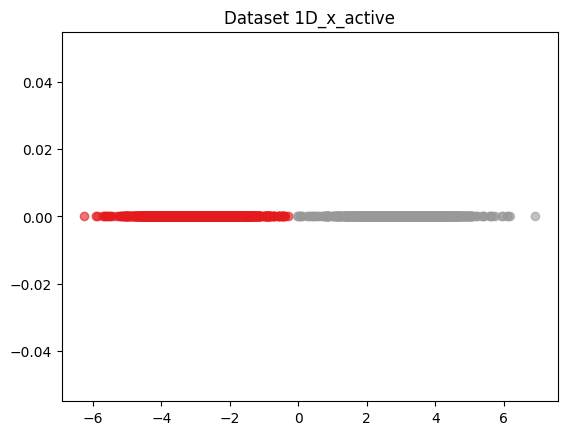

In [30]:
datasets["1D_x_active"]
df = datasets["1D_x_active"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 1D_x_active")
plt.show()

In [12]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["1D_x_active"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["1D_x_active"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(600)

In [13]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.001333,0.002000,0.001333,0.000667,0.001000
120,0.001333,0.008667,0.001333,0.000000,0.000667
24,0.001333,0.030667,0.001333,0.000000,0.000667
4,0.001333,0.752000,0.001333,0.000000,0.000667


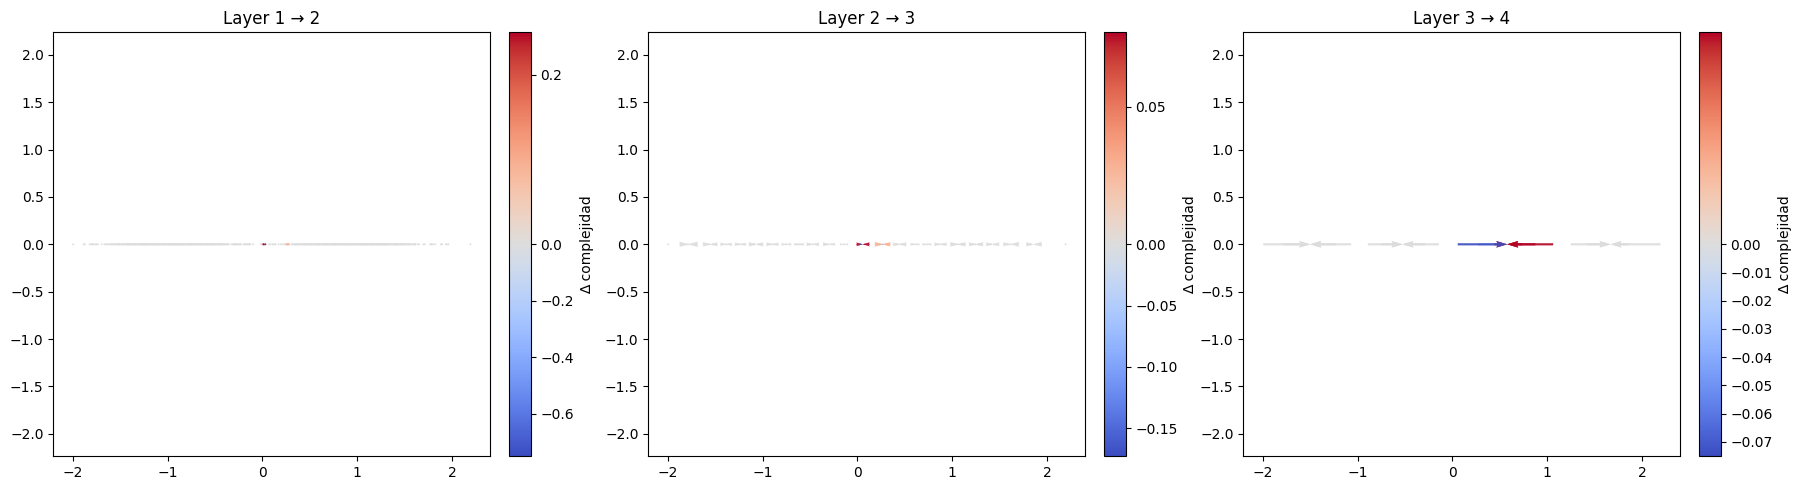

In [14]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

In [18]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)

/home/carmen/PycharmProjects/FeatureSelection_Complexity/TrackingCentroidsMovement.py:552: RuntimeWarning: invalid value encountered in divide
  norm_mov_vec = vec / mov if np.any(mov > 0) else vec


In [32]:
resultados['scores']

{'raw': {0: -0.027217373192346656, 1: 0.0},
 'normalized_simple': {0: -1.0, 1: 0.0},
 'robust': {0: -0.19685470462599414, 1: 0.0},
 'norm_by_movement': {0: -0.0017591294484871696, 1: nan},
 'robust_norm_by_movement': {0: -0.00019881895901281544, 1: nan}}

Vemos que el score de la variable y que permanece inactiva es siempre 0 y el de la variable x es negativo, lo que indica que es útil para reducir la complejidad.
De la capa 1 a la capa 2 vemos que sale que aumenta la complejidad pero es un valor realmente despreciable.

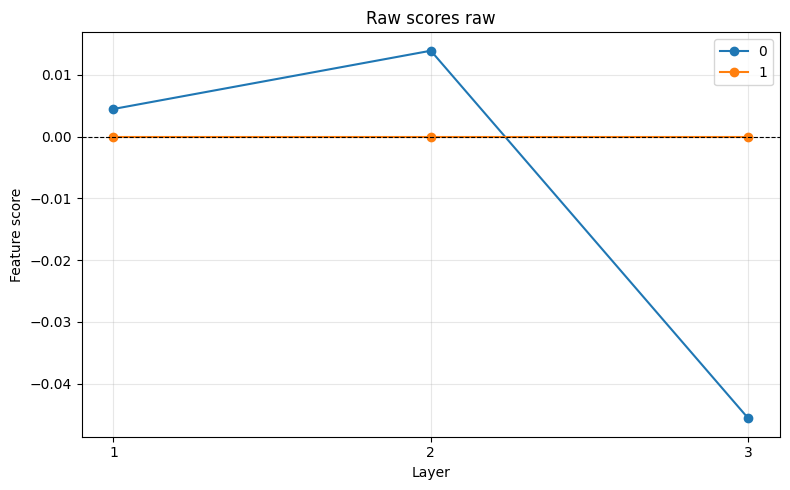

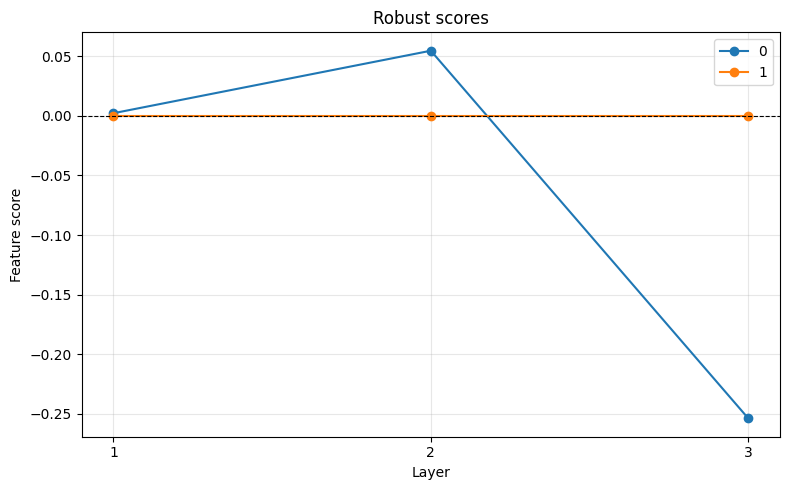

In [29]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'], feature_cols, title="Raw scores raw")
plot_scores_by_layer(resultados['list_scores_robust'], feature_cols, title="Robust scores")


## Dataset 2: 1D x inactiva

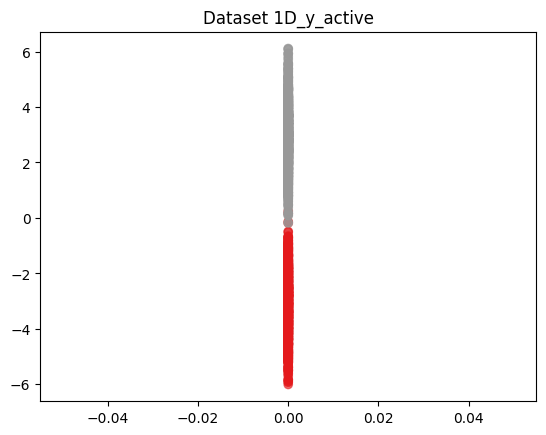

In [40]:
df = datasets["1D_y_active"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 1D_y_active")
plt.show()

In [41]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["1D_y_active"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["1D_y_active"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(120)

In [42]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.002000,0.004000,0.002000,0.000667,0.001333
120,0.002667,0.005333,0.002000,0.000667,0.001333
24,0.002667,0.005333,0.002000,0.000000,0.001000
4,0.002667,0.458667,0.002667,0.000000,0.001333


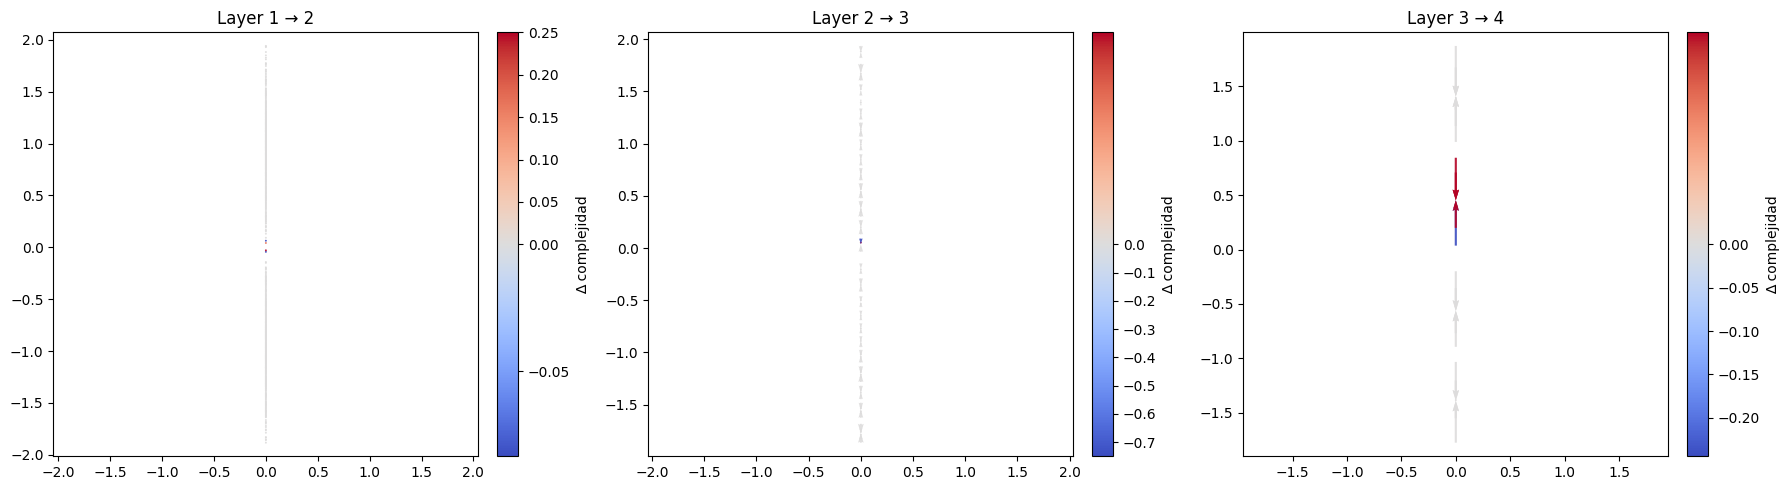

In [43]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

In [44]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

/home/carmen/PycharmProjects/FeatureSelection_Complexity/TrackingCentroidsMovement.py:552: RuntimeWarning: invalid value encountered in divide
  norm_mov_vec = vec / mov if np.any(mov > 0) else vec


{'raw': {0: 0.0, 1: -0.13401836548578913},
 'normalized_simple': {0: 0.0, 1: -1.0},
 'robust': {0: 0.0, 1: -0.29009055233087067},
 'norm_by_movement': {0: nan, 1: -0.00948883521153274},
 'robust_norm_by_movement': {0: nan, 1: -0.00034308279197068503}}

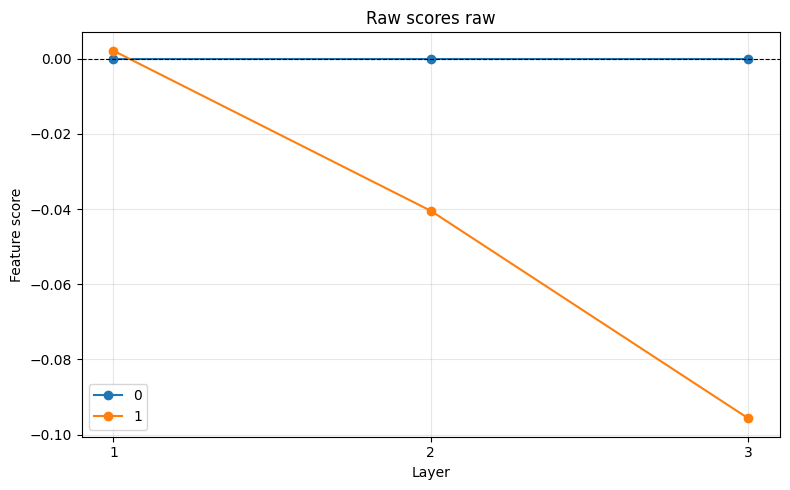

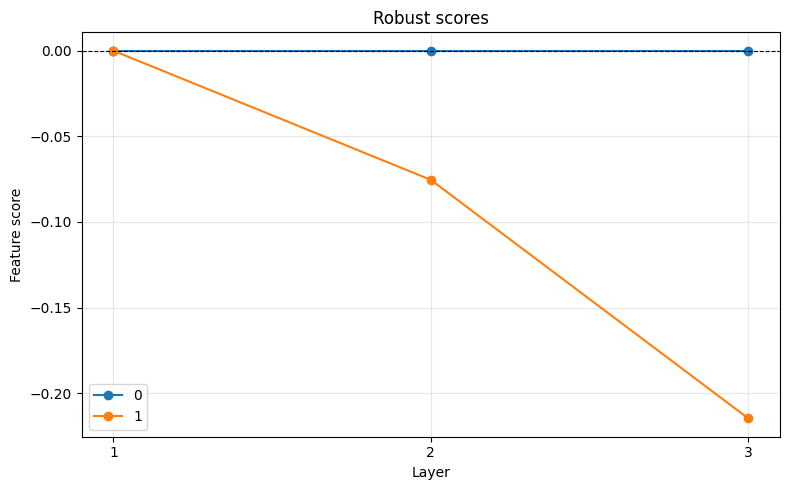

In [50]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'], feature_cols, title="Raw scores raw")
plot_scores_by_layer(resultados['list_scores_robust'], feature_cols, title="Robust scores")

Con la x inactiva vemos que el comportamiento también es el esperado: la variable x no aporta nada y la variable y ayuda a minimizar la complejidad.

## Dataset 3: Normales separadas en 2D

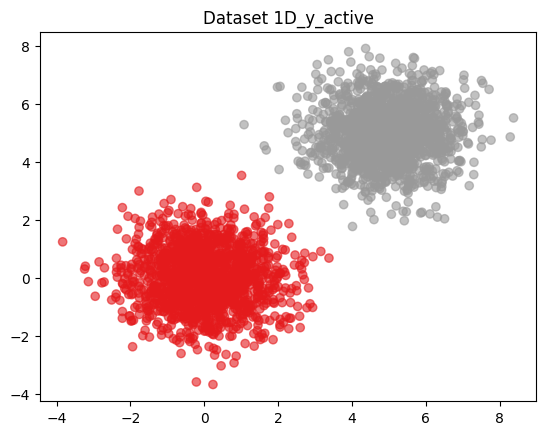

In [51]:
df = datasets["2D_blobs"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [54]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [55]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.000000,0.000000,0.0,0.0,0.0
120,0.000000,0.000000,0.0,0.0,0.0
24,0.006000,0.000667,0.0,0.0,0.0
4,0.566667,0.000667,0.0,0.0,0.0


In [59]:
# plot_hierarchical_quivers_with_complexity(
#     data_clusters,
#     centroids_dict,
#     host_instance_by_layer_df,
#     delta=0.5,
#     k_auto=4)
# como todo es 0, no se pinta

In [57]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: 0.0, 1: 0.0},
 'normalized_simple': {0: 0.0, 1: 0.0},
 'robust': {0: 0.0, 1: 0.0},
 'norm_by_movement': {0: 0.0, 1: 0.0},
 'robust_norm_by_movement': {0: 0.0, 1: 0.0}}

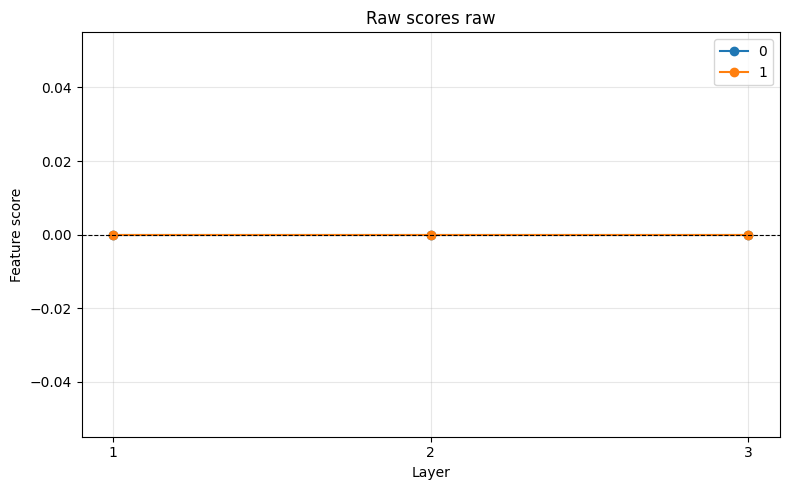

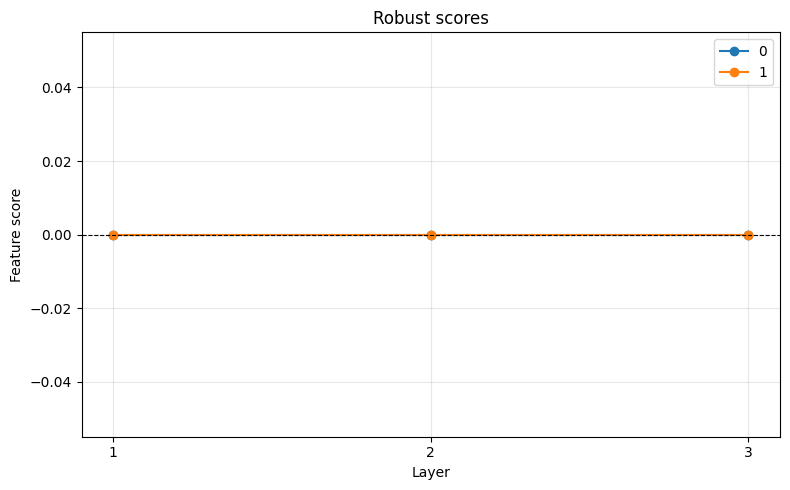

In [58]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'], feature_cols, title="Raw scores raw")
plot_scores_by_layer(resultados['list_scores_robust'], feature_cols, title="Robust scores")

Aquí tenemos un "problema": como la complejidad es 0 al ser clases totalmente separadas, no se llega a sacar información de qué variable es más discriminante. ¿Qué pasa si hay otra redundante? Lo estudiamos a continuación con el dataset 4 (que realmente es el 6 en la creación de datasets).

## Dataset 4: 2 normales separadas + 1 variable rendundante

Estudiamos ahora el caso previo pero añadiendo una variable redundante.

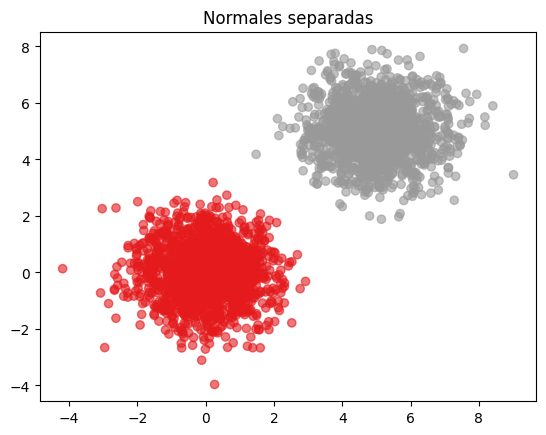

In [60]:
df = datasets["3D_redundant"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [61]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [63]:
# plot_hierarchical_quivers_with_complexity(
#     data_clusters,
#     centroids_dict,
#     host_instance_by_layer_df,
#     delta=0.5,
#     k_auto=4)
# como todo es 0, no se pinta

In [64]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: 0.0, 1: 0.0, 2: 0.0},
 'normalized_simple': {0: 0.0, 1: 0.0, 2: 0.0},
 'robust': {0: 0.0, 1: 0.0, 2: 0.0},
 'norm_by_movement': {0: 0.0, 1: 0.0, 2: 0.0},
 'robust_norm_by_movement': {0: 0.0, 1: 0.0, 2: 0.0}}

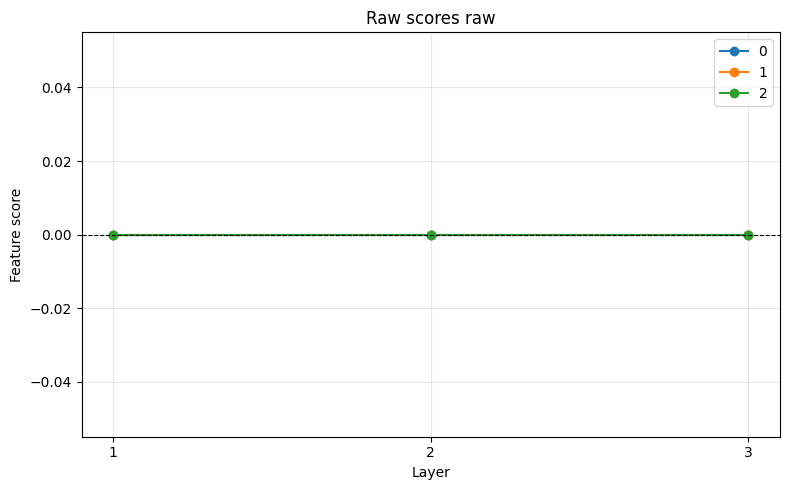

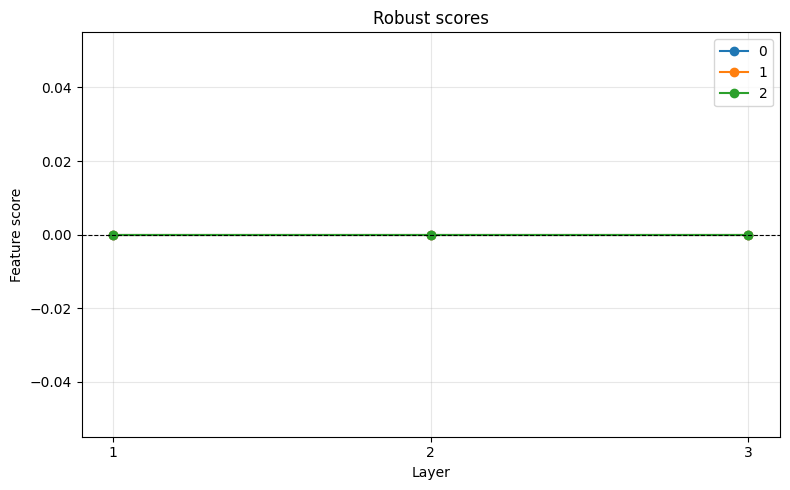

In [66]:
feature_cols = ["0", "1",'2']
plot_scores_by_layer(resultados['list_scores_raw'], feature_cols, title="Raw scores raw")
plot_scores_by_layer(resultados['list_scores_robust'], feature_cols, title="Robust scores")

Problema: no detecta que hay una redundante. En este caso estamos claramente a ciegas.

TENG QUE SACAR TAMBIÉN UN RANKING DEL MOVIMIENTO, NO SOLO DE LA COMPLEJIDAD

## Dataset 5: Normales, x discrimina, y ruido

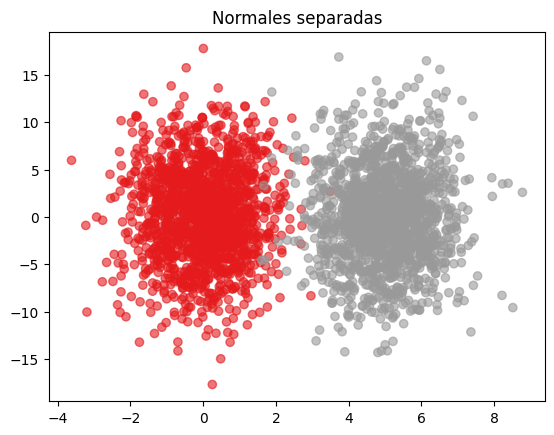

In [67]:
df = datasets["2D_x_relevant"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [68]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(120)

In [69]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.019333,0.015333,0.004667,0.007333,0.006000
120,0.096667,0.066667,0.004000,0.006667,0.005333
24,0.598667,0.417333,0.008000,0.006667,0.007333
4,1.000000,1.000000,0.008667,0.006667,0.007667


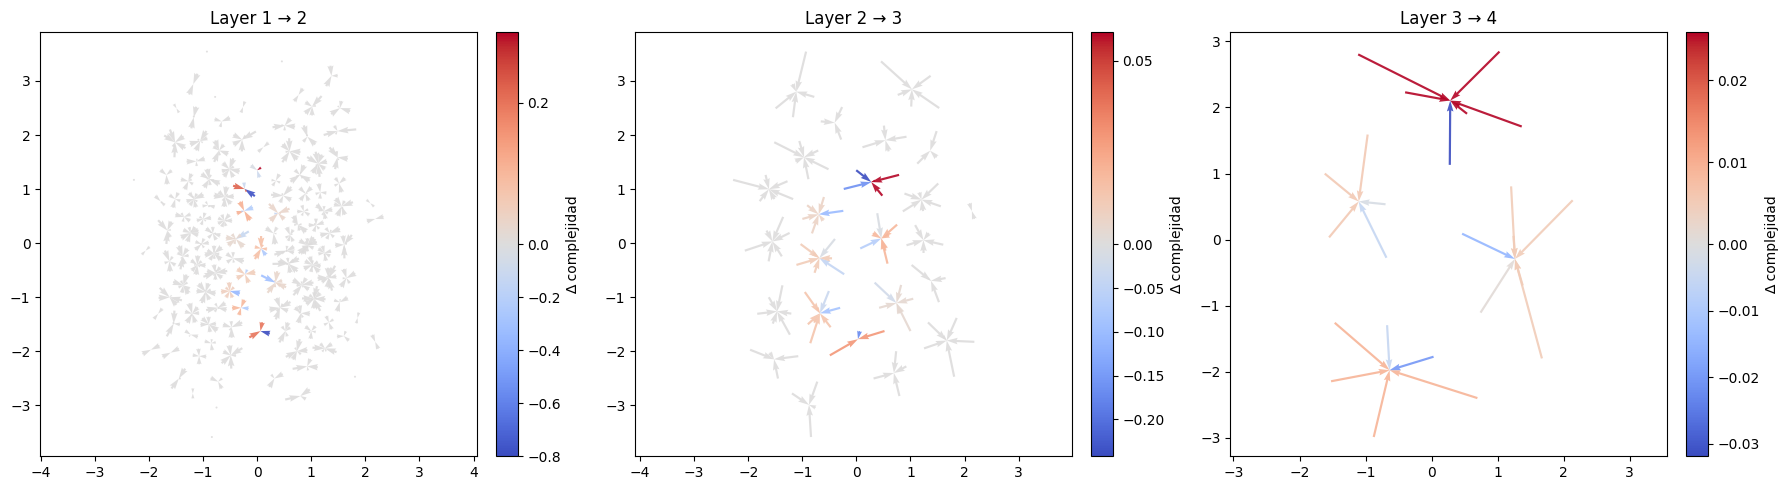

In [70]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

Claramente irte hacia el centro empeora e irte hacia fuera mejora. La última capa realmente sobra, ya no queda tan claro.

In [71]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: -0.3193920135306404, 1: -0.017646711830238502},
 'normalized_simple': {0: -0.9476418865181039, 1: -0.05235811348189607},
 'robust': {0: 1.444033125460463, 1: 0.645607305837648},
 'norm_by_movement': {0: -0.0033771662522705053, 1: -0.00018299537342295635},
 'robust_norm_by_movement': {0: 0.0006920932551509686,
  1: 0.00023535707439621372}}

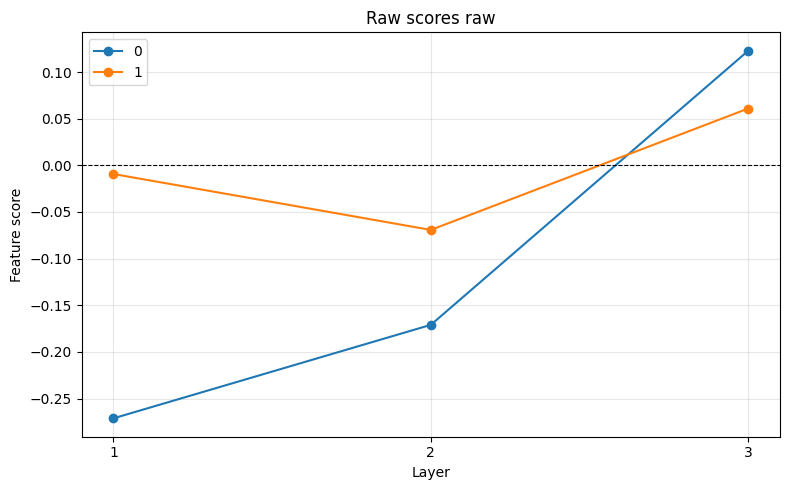

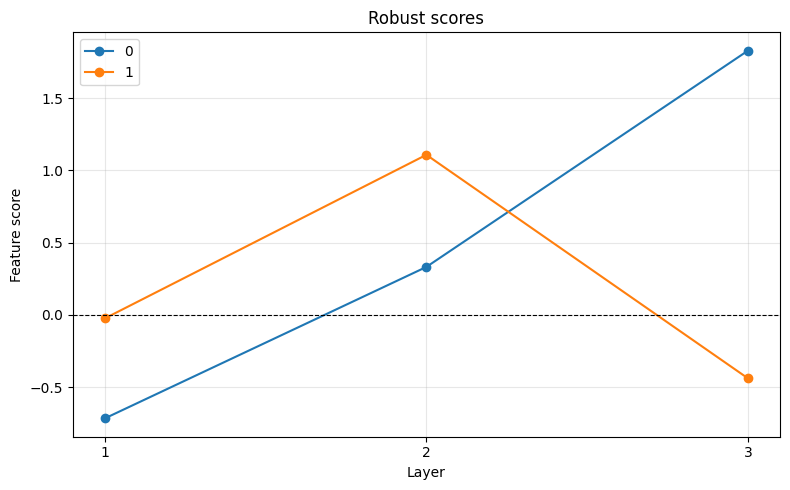

In [72]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'], feature_cols, title="Raw scores raw")
plot_scores_by_layer(resultados['list_scores_robust'], feature_cols, title="Robust scores")

Ordena correctamente las variables pero también le da algo de puntos a la variable y. La última capa sobra claramente.

## Dataset 5: XOR

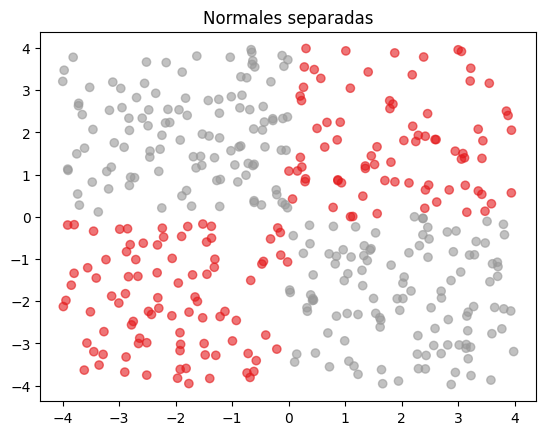

In [92]:
df = datasets["2D_XOR"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [93]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(80)

In [94]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
80,0.116959,0.117904,0.040936,0.021834,0.0300
16,0.444444,0.567686,0.058480,0.013100,0.0325
3,1.000000,1.000000,0.058480,0.013100,0.0325


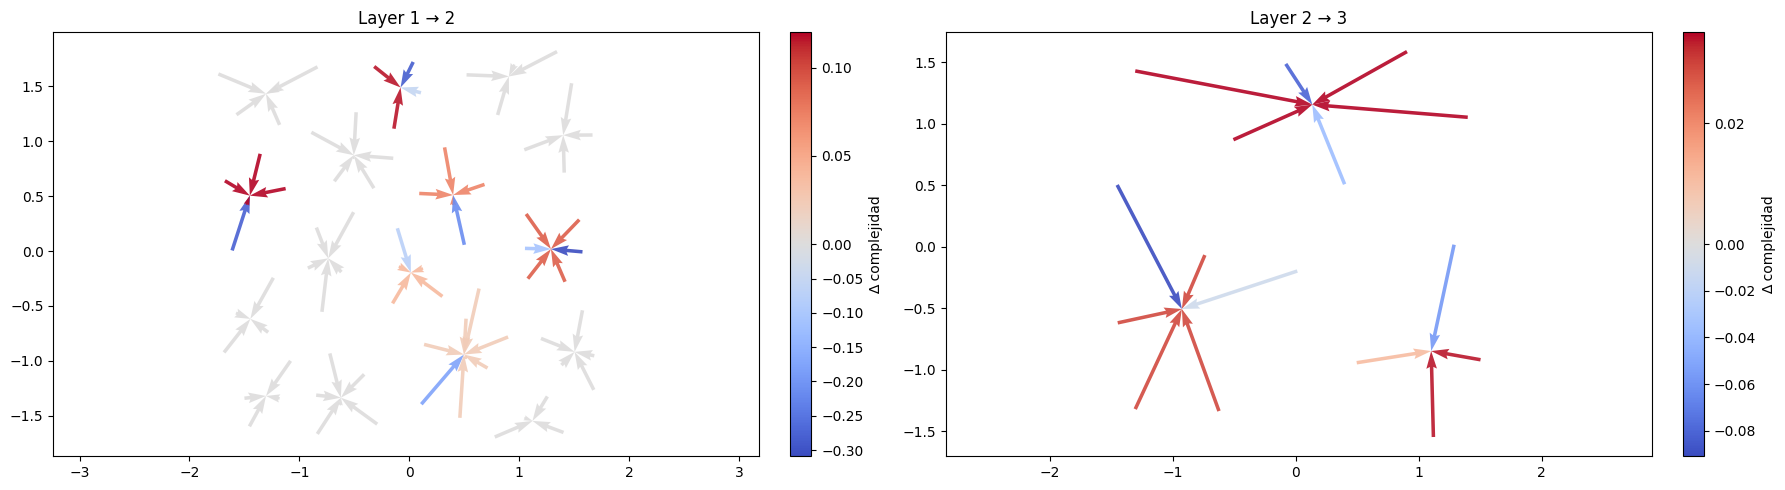

In [95]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=3)

El último gráfico claramente sobra. Visualmente el primer gráfico tampoco aclara mucho.

In [100]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=16)
resultados['scores']

{'raw': {0: -0.009859873182686843, 1: -0.06186882931098405},
 'normalized_simple': {0: -0.13746063765138994, 1: -0.8625393623486102},
 'robust': {0: 0.14411095123153328, 1: -0.3935082648199594},
 'norm_by_movement': {0: -0.0006550397981333674, 1: -0.0036173134666420853},
 'robust_norm_by_movement': {0: 0.0019015438404563823,
  1: -0.004383559060759907}}

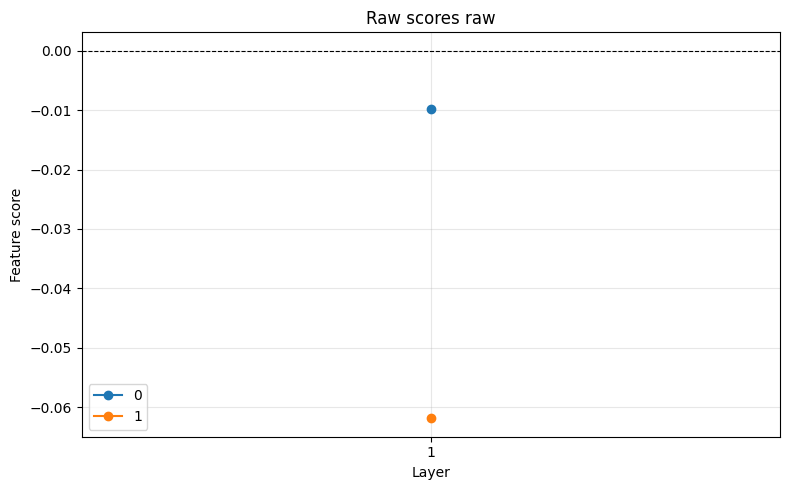

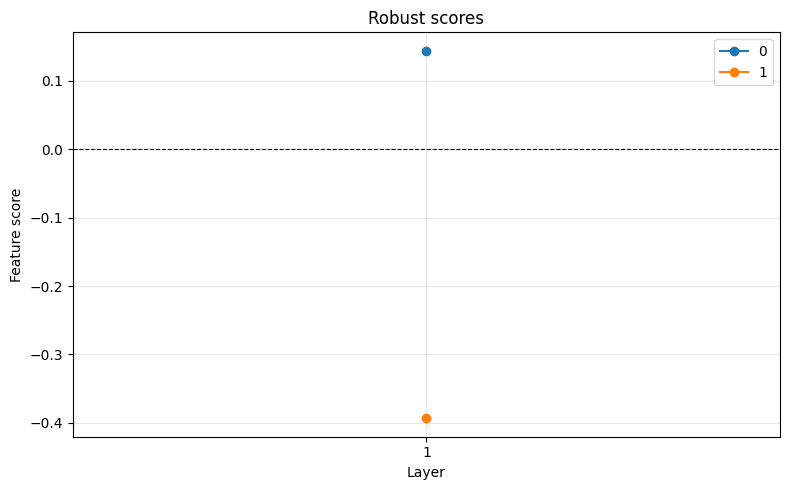

In [101]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'], feature_cols, title="Raw scores raw")
plot_scores_by_layer(resultados['list_scores_robust'], feature_cols, title="Robust scores")

Pasa realmente similar que con las Normales totalmente separadas. Este es un dataset sin complejidad.